In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
import sys
sys.path.append('../../../modules')

In [2]:
# Import useful libraries for analysis
import pandas as pd
import hist
from hist import Hist
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path 
import hashlib
import itertools
import glob
import io
from contextlib import redirect_stdout, redirect_stderr

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [3]:
# Import the nEXO sensitivity classes
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [4]:
basedir = Path('/p/lustre2/nexouser/samuele/multivarstudy')
outputdir = basedir / 'output'
plotdir = Path('plots')
os.makedirs(plotdir, exist_ok=True)

In [5]:
dnn_factors_d = {0.:7.15, 0.15:8.57, 0.177:10.06, 0.2:12.30, 0.25:19.73} # these come from dnn_smoothing notebook
dnn_factors = dnn_factors_d.keys()
xe137_scale_factors = [1., 1.2, 1.5, 2., 3., ]
rn222_scale_factors = [1., 1.2, 1.5, 2., 3., ]
bkg_scale_factors = [1., 1.2, 1.5, 2., 3., ]
energy_res_factors = [0.008, 0.01, 0.012, 0.014]

# dnn_factors_d = {0.:7.15, } # these come from dnn_smoothing notebook
# dnn_factors = dnn_factors_d.keys()
# xe137_scale_factors = [1.,  ]
# rn222_scale_factors = [1.,  ]
# bkg_scale_factors = [1.,  ]
# energy_res_factors = [0.008, 0.01, 0.012, 0.014]

df = pd.DataFrame(columns=['tag', 'dnn_f', 'bkg_misID', 'xe137_f', 'rn222_f', 'bkg_f', 
                           'energy_res_f', 'convergence_f', 
                           'median', 'sens', 'sens_1e28'])
df = df.set_index('tag')
display(df)

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28
tag,,,,,,,,,,


In [6]:
results_file = Path('multivar_study_results.h5')
# delete prior data if needed by uncommenting the following line
# this will result in all data being reloaded which may take some time:
# results_file.unlink()

In [7]:
# load prior data if available
if results_file.is_file():
    df = pd.read_hdf(results_file) 
#     display(df)
existing_tags = df.index
print(existing_tags)

Index(['C80461', '381874', '9F680C', '2568B2', 'D12AFD', '65F25B', '9AB3ED',
       '93D399', '14784F', '0556BF', '4BA205', '9277A1', '5AA481', '1330A7',
       '85CFF9', '0E9071', 'A6EDCF', '54A571', '5E6C53', '91C156', '8E1210',
       '392E34', 'DE3D44', '99E718', 'C8BAC8', 'AE9E98', 'F6CEBD', 'AF5201',
       '4C2555', '20D857', '639AE2', '6F5CBC', '25356C', '44A209', 'F4CBD6',
       '9BBE74', 'A6BA89', '20E48D', 'F1395D', 'E4146C', '0E80EC', '6B31EB',
       '16D2B8', 'FA8BEA', '3321A1', '4B37E3', 'C0FEAE', 'B41D83', '7D927A',
       'C56667', 'B9A9CC', '0B7D99', '5C68BF', '50D8DD', 'C91EB8', 'BE466B',
       'FA4545', '63C161', '5C36DF', 'FDFF8F', '0999EA', '09DD31', '7E8B41',
       '04478F', '332CB6', 'CE1213', '6899FD', '2461C9', '83BAFF', 'DBF69F',
       'A516CD', '1E85A6', '28DD32', '786870', '7DD6E3', 'EBF57F', 'AD42F2',
       '7A7C15', '800AAD'],
      dtype='object', name='tag')


In [8]:
def get_tag(xe137_scale_factor, rn222_scale_factor, dnn_scale_factor, bkg_scale_factor, energy_res):
    # This should match the hash string used in Compute90PercentLimit script 
    # FIXME: hash should not be calculated both here and Compute90PercentLimit
    s = f'Xe137:{xe137_scale_factor:0>4.4f} ' + \
        f'Rn222:{rn222_scale_factor:0>4.4f} ' + \
        f'DNN:{dnn_scale_factor:0>4.4f} ' + \
        f'Bkg:{bkg_scale_factor:0>4.4f} ' + \
        f'ERes:{energy_res:0>4.4f}'
    return hashlib.md5(s.encode('utf-8')).hexdigest()[:6].upper(), s

In [9]:
def get_expected_counts(df, xe137_scale_factor, rn222_scale_factor, dnn_f, bkg_scale_factor, energy_res_f):
    config = '/g/g92/samuele/nEXO/sensitivity/work/SensitivityPaper2020_scripts/MultivariationStudy/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml'
    input_table = basedir / 'ComponentsTables' / f'ComponentsTable_D-024_DNN_factor={dnn_f}_ERes={energy_res_f}.h5'    
    
    if not input_table.is_file(): 
        return
    
    tag, s = get_tag(xe137_scale_factor, rn222_scale_factor, dnn_f, bkg_scale_factor, energy_res_f)

    h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
    
    if h5_files:
        workspace = nEXOFitWorkspace.nEXOFitWorkspace(config)
        workspace.LoadComponentsTableFromFile(input_table)

        for index, row in workspace.df_components.iterrows():
        # Scale the gamma ray background components, except radon
            isotopes_to_leave_alone = ['Ar42', 'Xe137', 'bb2n', 'bb0n', 'B8nu', 'Rn222', ]  # just for bookkeeping
            isotopes_to_scale = ['K40', 'Co60', 'Al26', 'Th232', 'U238', 'Cs137']
            # The format is <isotope>_<part>, e.g. "Th232_HVCables"
            if row['PDFName'].split('_')[0] in isotopes_to_scale:
                print(f'Scaling {row["PDFName"]}...')
                workspace.df_components.loc[index, 'SpecActiv'] = bkg_scale_factor * row['SpecActiv']
                workspace.df_components.loc[index, 'SpecActivErr'] = bkg_scale_factor * row['SpecActivErr']

            # Scale the Xe137 component.
            if 'Xe137' in row['PDFName']:
                workspace.df_components.loc[index, 'SpecActiv'] = xe137_scale_factor * row['SpecActiv']
                workspace.df_components.loc[index, 'SpecActivErr'] = xe137_scale_factor * row['SpecActivErr']

        workspace.CreateGroupedPDFs()

        # Define the ROI within the workspace
        # Note that the ROI energy depends on the resolution since it's +/- FWHM/2
        fwhm = 2457 * energy_res_f * 2.35
        roi_dict = {'DNN': [0.85, 1.],
                    'Energy (keV)': [2457. - fwhm/2., 2457. + fwhm/2.],
                    'Standoff (mm)': [104.5, 650.]}
        workspace.DefineROI(roi_dict)
#         print(workspace.df_components.loc[0])

        # Create the likelihood object
        likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
        likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs, workspace.histogram_axis_names)

        initial_guess = likelihood.GetVariableValues()

        # Scale the Rn222 component according to the input value
        rn222_idx = likelihood.model.GetVariableIndexByName('Rn222')
        initial_guess[rn222_idx] *= rn222_scale_factor

        # Update the model in the likelihood object
        likelihood.model.UpdateVariables(initial_guess)
        likelihood.model.GenerateModelDistribution()

        # Print out the number of events in the ROI
        df.at[tag, 'TotalROIBkg'] = likelihood.model.GetIntegralInBinRange(workspace.GetROIBinIndices())

        for component in likelihood.model.variable_list:
            if 'Shape' in component['Name']:
                continue
            num_counts_in_roi = likelihood.model.GetComponentIntegralInBinRange(
                component['Name'], workspace.GetROIBinIndices())
            df.at[tag, component['Name']] = num_counts_in_roi
    #         print(f'{component["Name"] + ":":<20}\t'
    #               f'{num_counts_in_roi:>10.4}\t'
    #               f'{int(1000 * num_counts_in_roi / total_bkg_in_roi) / 10.:>10.4}%')

# Load Data

In [10]:
dfdict = dict()
for dnn_scale_factor, xe137_scale_factor, rn222_scale_factor, bkg_scale_factor, energy_res \
        in itertools.product(dnn_factors, xe137_scale_factors, rn222_scale_factors, bkg_scale_factors,
                             energy_res_factors):

    tag, s = get_tag(xe137_scale_factor, rn222_scale_factor, dnn_scale_factor, bkg_scale_factor, energy_res)
    
    if tag in existing_tags: continue  # don't process if already exists in dataframe
    
    h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
    if h5_files:
        print(f'Loading data for tag {tag}')
        print(s)
        df_list = [pd.read_hdf(outputdir/Path(filename)) for filename in h5_files]
        dfdict[tag] = pd.concat(df_list, ignore_index=True)
        print(f'---> Loaded {len(dfdict[tag])} toy datasets')
        
        data = {'dnn_f':dnn_scale_factor, 'bkg_misID':dnn_factors_d[dnn_scale_factor],
                'xe137_f':xe137_scale_factor, 'rn222_f':rn222_scale_factor, 
                'bkg_f':bkg_scale_factor, 'energy_res_f':energy_res, }
        df.loc[tag] = data
        
        with redirect_stdout(io.StringIO()):    # capture output so it won't pollute the terminal
            with redirect_stderr(io.StringIO()):
                get_expected_counts(df, xe137_scale_factor, rn222_scale_factor, dnn_scale_factor, bkg_scale_factor, energy_res)  
        print(f"---> Loaded expected counts. Total ROI counts: {df.at[tag, 'TotalROIBkg']}")
        print('---------------------------')

#     else:
#         print(f'No data found for tag {tag}')

In [11]:
display(df)

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
C80461,0.20,12.30,3.0,3.0,3.0,0.012,0.994343,11.161116,7810806390589247841946828800.0,0.781081,...,0.638957,0.250159,1.669045,0.095564,6.613891,0.0,0.088050,0.281085,0.000020,0.317375
381874,0.20,12.30,2.0,2.0,2.0,0.014,0.993429,10.706071,8142793023724989615376957440.0,0.814279,...,0.440680,0.207138,1.121505,0.101710,3.630519,0.0,0.100993,0.467748,0.000020,0.245516
9F680C,0.20,12.30,3.0,3.0,3.0,0.010,0.9922,10.521052,8285988528419771944712273920.0,0.828599,...,0.625444,0.215933,1.458333,0.079544,5.142884,0.0,0.075631,0.073200,0.000021,0.271239
2568B2,0.20,12.30,3.0,2.0,2.0,0.012,0.990909,10.491049,8309685349759390786139455488.0,0.830969,...,0.425972,0.166773,1.112697,0.063709,4.409261,0.0,0.088050,0.281085,0.000020,0.317375
D12AFD,0.15,8.57,3.0,3.0,3.0,0.012,0.9926,10.371037,8405843714462489242794721280.0,0.840584,...,0.764333,0.271752,1.795899,0.115763,6.259640,0.0,0.106934,0.342160,0.000025,0.385271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7DD6E3,0.15,8.57,1.0,1.0,1.0,0.010,0.9926,6.870687,12688296844101312777352642560.0,1.26883,...,0.243774,0.077606,0.512617,0.034222,1.938810,0.0,0.091744,0.089199,0.000025,0.116635
EBF57F,0.15,8.57,1.0,1.0,1.0,0.008,0.9938,6.630663,13147601707236200136604385280.0,1.31476,...,0.245678,0.064566,0.558152,0.036802,1.925793,0.0,0.076263,0.042922,0.000026,0.097364
AD42F2,0.00,7.15,1.0,1.0,1.0,0.010,0.9942,6.60066,13207363533178183714120663040.0,1.320736,...,0.360002,0.109865,0.731235,0.056652,2.847172,0.0,0.142680,0.141177,0.000039,0.180591


In [12]:
# df_tmp = dfdict['A516CD']
# df_tmp.head()
# print("Number of Toys:", len(df_tmp))

# Compute the convergence fraction

In [13]:
good_fit_mask_dict = {}
for tag, df_fit in dfdict.items():
    if tag in existing_tags: continue  # don't process if already exists in dataframe
    good_fit_mask = []
    for index,row in df_fit.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01\
            or row['best_fit_nll'] > 0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
    convergence_f = np.sum(good_fit_mask)/len(df_fit)
    print(f'Tag {tag} convergence fraction: {convergence_f:3.3}')
    df.at[tag, 'convergence_f'] = convergence_f
    good_fit_mask_dict[tag] = good_fit_mask

In [14]:
display(df.loc[df['convergence_f']<0.99])

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
AE9E98,0.15,8.57,3.0,2.0,2.0,0.01,0.989697,8.770877,9939406991901484061344923648.0,0.993941,...,0.487548,0.155213,1.025233,0.068445,3.87762,0.0,0.091744,0.089199,0.000025,0.326458


# Compute Median and 90% CL Sensitivity

In [15]:
def calc_atoms_136(enrichment_fraction=0.9):
    """ Number of Xe136 atoms in nEXO fiducial volume """
    mmass134 = 0.133905395  # kg/mol 134
    mmass136 = 0.135907219  # kg/mol 136
    at_frac = enrichment_fraction           # atomic fraction 136 / (136 + 134)
    avog_num = 6.022141E23  # Avogadro's number
    fid_mass = 3281         # mass of fiducial volume [kg]

    atoms136 = (fid_mass * avog_num * at_frac) / ((mmass136 * at_frac) + ((1 - at_frac) * mmass134))

    return atoms136


def ComputeHalflifeFromNumCounts(counts, enrichment_fraction=0.9, lifetime=10):
    """Calculate the sensitivity of nEXO in terms of half-life (years)"""
    atoms136 = calc_atoms_136(enrichment_fraction)
    eff = 0.9598  # hit efficiency
    sensitivity = eff * atoms136 * lifetime * np.log(2) / counts
    return sensitivity


def ComputeCountsFromHalflife(sensitivity, enrichment_fraction=0.9, lifetime=10):
    """Calculate the sensitivity of nEXO in terms of half-life (years)"""
    atoms136 = calc_atoms_136(enrichment_fraction)
    eff = 0.9598  # hit efficiency
    counts = eff * atoms136 * lifetime * np.log(2) / sensitivity
    return counts
    

# def ComputeHalflifeFromNumCounts( counts, enrichment_fraction=0.9 ):
#     '''Returns the half life which would give (on average) the input number of signal counts'''
    
#     N_A = 6.02e23 # atoms/mol
#     FidMass = 3281 # kg
#     AtomicMass = 135.8 # g/mol
#     SigEfficiency = 0.96
#     Livetime = 10 # years
#     return FidMass*1.e3 / AtomicMass * N_A * enrichment_fraction * Livetime * \
#             SigEfficiency * np.log(2) / counts


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Tag	Median [cts]	Sensitivity [y]


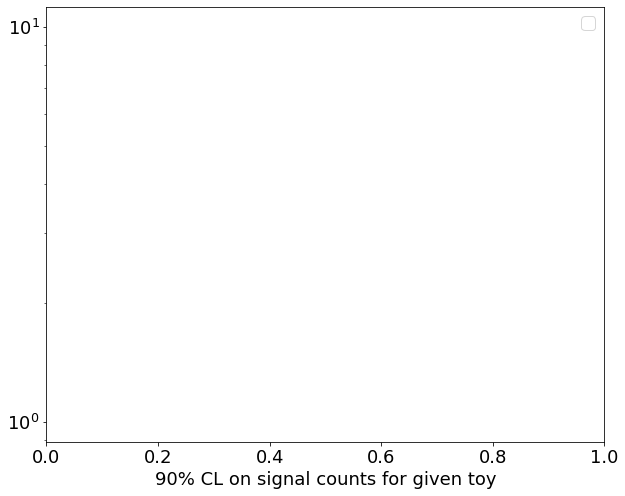

In [16]:
print('Tag\tMedian [cts]\tSensitivity [y]')
fig, ax = plt.subplots()
for tag, df_fit in dfdict.items():
    if tag in existing_tags: continue  # don't process if already exists in dataframe
    h = Hist.new.Regular(121, 0, 60, name="signal_counts").Double()
    values = df_fit['90CL_crossing'].loc[good_fit_mask_dict[tag]]
    h.fill(values)
    median = np.median(values)
    df.at[tag, 'median'] = median
    df.at[tag, 'sens'] = ComputeHalflifeFromNumCounts(median)
    print(f'{tag}\t{median:.3f}\t{df.at[tag, "sens"]:.3e}')
#     print(f'Results for tag {tag}')
#     print(f'   Median 90%CL on signal counts: {median:.3f}')
#     print(f'   Sensitivity: {df.at[tag, "sens"]:.3e} years')

    h.plot1d(ax=ax, label=f'{tag}')

plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')

In [17]:
# format_mapping = {"sens": "{:.3e}", }
# df.style.format(format_mapping)
# df['sens_str'] = df['sens'].apply('{:.3e}'.format)
df['sens_1e28'] = df['sens']/1e28
df = df.sort_values(by=['sens'])

In [18]:
display(df)
df.to_csv('multivar_results.csv')
df.to_hdf(results_file, 'df')

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
C80461,0.20,12.30,3.0,3.0,3.0,0.012,0.994343,11.161116,7810806390589247841946828800.0,0.781081,...,0.638957,0.250159,1.669045,0.095564,6.613891,0.0,0.088050,0.281085,0.000020,0.317375
381874,0.20,12.30,2.0,2.0,2.0,0.014,0.993429,10.706071,8142793023724989615376957440.0,0.814279,...,0.440680,0.207138,1.121505,0.101710,3.630519,0.0,0.100993,0.467748,0.000020,0.245516
9F680C,0.20,12.30,3.0,3.0,3.0,0.010,0.9922,10.521052,8285988528419771944712273920.0,0.828599,...,0.625444,0.215933,1.458333,0.079544,5.142884,0.0,0.075631,0.073200,0.000021,0.271239
2568B2,0.20,12.30,3.0,2.0,2.0,0.012,0.990909,10.491049,8309685349759390786139455488.0,0.830969,...,0.425972,0.166773,1.112697,0.063709,4.409261,0.0,0.088050,0.281085,0.000020,0.317375
D12AFD,0.15,8.57,3.0,3.0,3.0,0.012,0.9926,10.371037,8405843714462489242794721280.0,0.840584,...,0.764333,0.271752,1.795899,0.115763,6.259640,0.0,0.106934,0.342160,0.000025,0.385271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7DD6E3,0.15,8.57,1.0,1.0,1.0,0.010,0.9926,6.870687,12688296844101312777352642560.0,1.26883,...,0.243774,0.077606,0.512617,0.034222,1.938810,0.0,0.091744,0.089199,0.000025,0.116635
EBF57F,0.15,8.57,1.0,1.0,1.0,0.008,0.9938,6.630663,13147601707236200136604385280.0,1.31476,...,0.245678,0.064566,0.558152,0.036802,1.925793,0.0,0.076263,0.042922,0.000026,0.097364
AD42F2,0.00,7.15,1.0,1.0,1.0,0.010,0.9942,6.60066,13207363533178183714120663040.0,1.320736,...,0.360002,0.109865,0.731235,0.056652,2.847172,0.0,0.142680,0.141177,0.000039,0.180591


/usr/WS1/samuele/nexo_venv/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->Index(['convergence_f', 'median', 'sens', 'sens_1e28'], dtype='object')]

  pytables.to_hdf(


In [19]:
d = df.loc[df['xe137_f']==2.0]
display(d)
df_res_d = {}
for e_res in [0.008, 0.01, 0.012]:
    dd = d.loc[df['energy_res_f'] == e_res]

,dnn_f,bkg_misID,xe137_f,rn222_f,bkg_f,energy_res_f,convergence_f,median,sens,sens_1e28,...,Num_Vessel_U238,Num_Vessel_Th232,Num_Internals_U238,Num_Internals_Th232,Num_Rn222,Num_FullTPC_K40,Num_B8nu,Num_FullLXeBb2n,Num_FullLXeBb0n,Num_Xe137_and_Ar42
tag,,,,,,,,,,,,,,,,,,,,,
381874,0.200,12.30,2.0,2.0,2.0,0.014,0.993429,10.706071,8142793023724989615376957440.0,0.814279,...,0.440680,0.207138,1.121505,0.101710,3.630519,0.0,0.100993,0.467748,0.000020,0.245516
65F25B,0.177,10.06,2.0,2.0,2.0,0.014,0.992785,10.311031,8454762300579631934570758144.0,0.845476,...,0.469656,0.207176,1.010942,0.076761,3.870475,0.0,0.109735,0.512333,0.000022,0.265649
93D399,0.150,8.57,2.0,2.0,2.0,0.014,0.991571,9.990999,8725585517415015220904984576.0,0.872559,...,0.518647,0.218265,1.105655,0.097577,4.262379,0.0,0.122081,0.572645,0.000025,0.296117
14784F,0.200,12.30,2.0,2.0,2.0,0.012,0.992727,9.980998,8734328589075751849020096512.0,0.873433,...,0.425972,0.166773,1.112697,0.063709,4.409261,0.0,0.088050,0.281085,0.000020,0.215351
9277A1,0.177,10.06,2.0,2.0,2.0,0.012,0.993218,9.650965,9033015473469016140020711424.0,0.903302,...,0.431241,0.185369,1.034692,0.072551,4.087377,0.0,0.095692,0.308104,0.000022,0.233988
0E9071,0.200,12.30,2.0,2.0,2.0,0.010,0.991,9.320932,9352854004181973826663350272.0,0.935285,...,0.416963,0.143955,0.972222,0.053029,3.428590,0.0,0.075631,0.073200,0.000021,0.184048
54A571,0.000,7.15,2.0,2.0,2.0,0.014,0.990429,9.140914,9537045877349672359559168000.0,0.953705,...,0.668216,0.304300,1.597375,0.130841,4.976143,0.0,0.190324,0.893937,0.000038,0.461262
5E6C53,0.177,10.06,2.0,2.0,2.0,0.010,0.992143,9.060906,9621258202977484803011510272.0,0.962126,...,0.476096,0.146905,0.963861,0.054189,4.540423,0.0,0.082203,0.078165,0.000023,0.199134
91C156,0.150,8.57,2.0,2.0,2.0,0.012,0.9928,9.050905,9631889427511161141994717184.0,0.963189,...,0.509555,0.181168,1.197266,0.077175,4.173093,0.0,0.106934,0.342160,0.000025,0.261418


In [20]:
df.columns

Index(['dnn_f', 'bkg_misID', 'xe137_f', 'rn222_f', 'bkg_f', 'energy_res_f',
       'convergence_f', 'median', 'sens', 'sens_1e28', 'TotalROIBkg',
       'Num_Far', 'Num_Vessel_U238', 'Num_Vessel_Th232', 'Num_Internals_U238',
       'Num_Internals_Th232', 'Num_Rn222', 'Num_FullTPC_K40', 'Num_B8nu',
       'Num_FullLXeBb2n', 'Num_FullLXeBb0n', 'Num_Xe137_and_Ar42'],
      dtype='object')

# Plots grouped by DNN Smearing factor

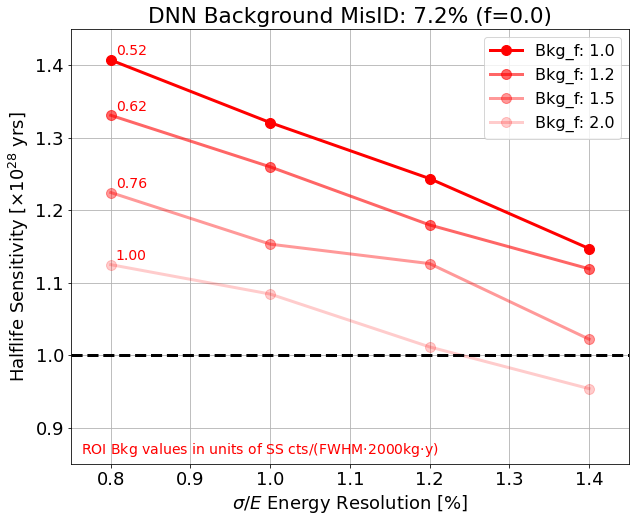

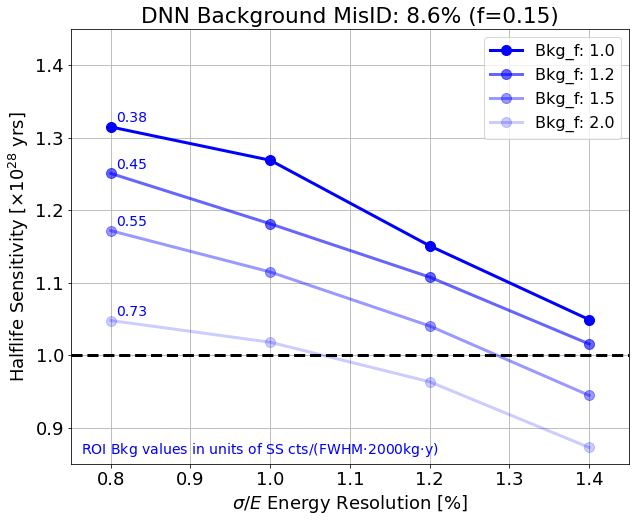

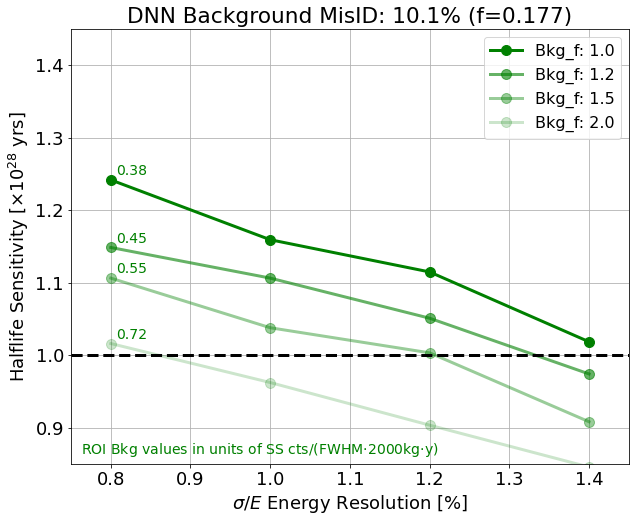

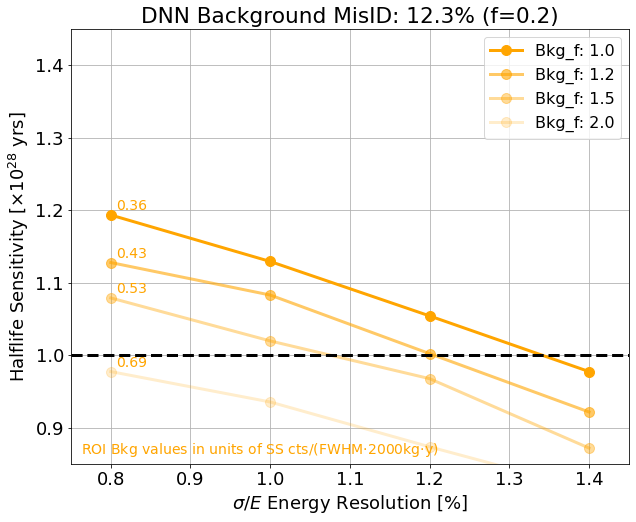

In [21]:
colors = ['r', 'b', 'g', 'orange']
alphas = [1.0, 0.6, 0.4, 0.2]
for i, dnn_f in enumerate([0., 0.15, 0.177, 0.2]):
    d = df.loc[(df['dnn_f']==dnn_f) & (df['rn222_f'] == df['bkg_f']) & (df['rn222_f'] == df['xe137_f'])]
    #display(d.sort_values(by=['energy_res_f']))
    for j, bkg_f in enumerate([1.0, 1.2, 1.5, 2.0]):
        dd = d.loc[df['bkg_f'] == bkg_f]
        if not len(dd): continue
        if bkg_f == 1.5:
            dt = df.loc[(df['dnn_f']==dnn_f) & (df['rn222_f'] == df['bkg_f']) & (df['xe137_f'] == 1.) & (df['bkg_f'] == bkg_f)]
#             if len(dt):
#                 plt.plot(dt.energy_res_f*100, dt.sens_1e28,'--s', color=colors[i], 
#                      markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f} (no Xe137 scaling)") #DNN_f: {dnn_f}
#                 for (x,y,z) in zip(dt.energy_res_f*100, dt.sens_1e28, dt.TotalROIBkg/10.):
#                     if x == min(dt.energy_res_f)*100:
#                         plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
#                                            color=colors[i], fontsize=14)
        plt.plot(dd.energy_res_f*100, dd.sens_1e28,'-o', color=colors[i], 
                 markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f}") #DNN_f: {dnn_f}
        for (x,y,z) in zip(dd.energy_res_f*100, dd.sens_1e28, dd.TotalROIBkg/10.):
            if x == min(dd.energy_res_f)*100:
                plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
                                   color=colors[i], fontsize=14)
    
    plt.gca().annotate(r'ROI Bkg values in units of SS cts/(FWHM$\cdot$2000kg$\cdot$y)', 
                       xy=(10,10), xycoords='axes points', color=colors[i], fontsize=14)       
    plt.xlim((0.75,1.45))    
    plt.ylim((0.85,1.45))    
    plt.title(f'DNN Background MisID: {dnn_factors_d[dnn_f]:.1f}% (f={dnn_f})')
    plt.xlabel(r'$\sigma/E$ Energy Resolution [%]')
    plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
    handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
    plt.legend(handles, labels, fontsize=16)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=3,)
    plt.grid()
    plt.savefig(plotdir / f'Multivar_study_by_DNN_{dnn_f}.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
    plt.show()

# Plots grouped by Energy Resolution

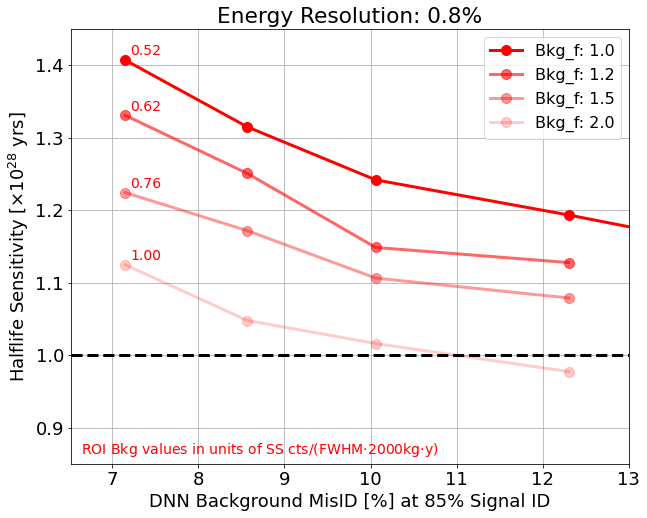

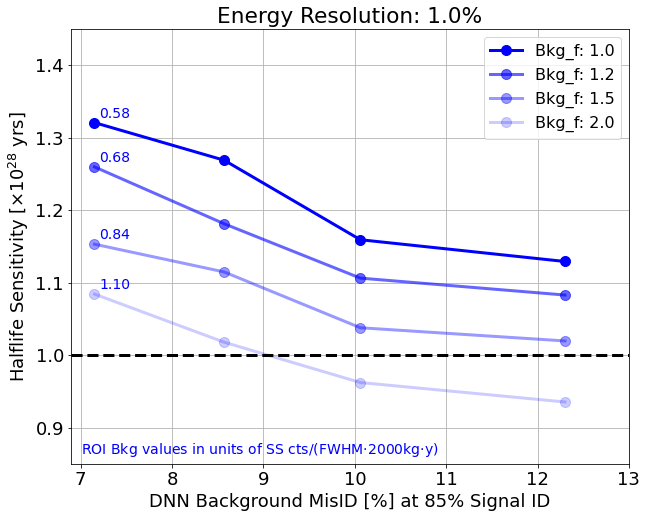

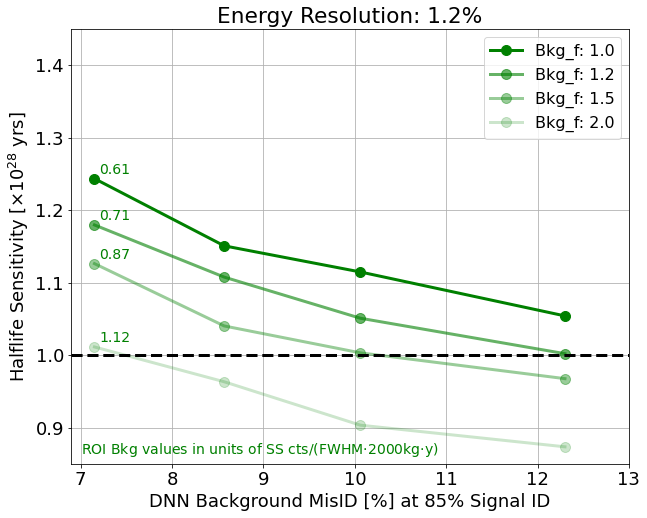

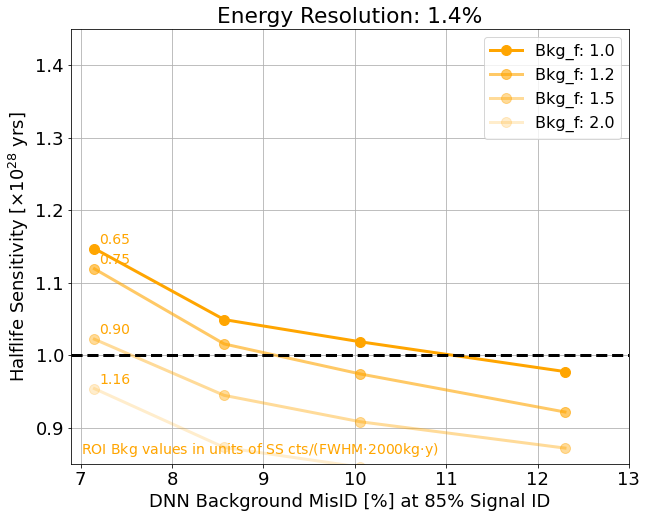

In [22]:
colors = ['r', 'b', 'g', 'orange']
alphas = [1.0, 0.6, 0.4, 0.2]
for i, energy_res_f in enumerate([0.008, 0.01, 0.012, 0.014]):
    d = df.loc[(df['energy_res_f']==energy_res_f) & (df['rn222_f'] == df['bkg_f']) & (df['rn222_f'] == df['xe137_f'])]
    #display(d.sort_values(by=['energy_res_f']))
    for j, bkg_f in enumerate([1.0, 1.2, 1.5, 2.0]):
        dd = d.loc[df['bkg_f'] == bkg_f]
        if not len(dd): continue
#         if bkg_f == 1.5:
#             dt = df.loc[(df['energy_res_f']==energy_res_f) & (df['rn222_f'] == df['bkg_f']) & (df['xe137_f'] == 1.) & (df['bkg_f'] == bkg_f)]
#             if len(dt):
#                 plt.plot(dt.bkg_misID, dt.sens_1e28,'--s', color=colors[i], 
#                      markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f} (no Xe137 scaling)") #DNN_f: {dnn_f}
#                 for (x,y,z) in zip(dt.bkg_misID, dt.sens_1e28, dt.TotalROIBkg/10.):
#                     plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
#                                        color=colors[i], fontsize=14)
        plt.plot(dd.bkg_misID, dd.sens_1e28,'-o', color=colors[i], 
                 markersize=10, linewidth=3, alpha=alphas[j], label=f"Bkg_f: {bkg_f}") # , ERes: {energy_res_f}
        for (x,y,z) in zip(dd.bkg_misID, dd.sens_1e28, dd.TotalROIBkg/10.):
            if x == min(dd.bkg_misID):
                plt.gca().annotate(f'{z:.2f}', xy=(x,y), xytext=(5,5), textcoords='offset points', 
                                   color=colors[i], fontsize=14)

    plt.gca().annotate(r'ROI Bkg values in units of SS cts/(FWHM$\cdot$2000kg$\cdot$y)', 
                       xy=(10,10), xycoords='axes points', color=colors[i], fontsize=14)       
    plt.xlim((None,13))
    plt.ylim((0.85,1.45))    
    plt.title(f'Energy Resolution: {energy_res_f*100:.1f}%')
    plt.xlabel(r'DNN Background MisID [%] at 85% Signal ID')
    plt.ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
    plt.legend(fontsize=16)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=3,)
    plt.grid()
    plt.savefig(plotdir / f'Multivar_study_by_ERes_{energy_res_f}.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
    plt.show()

# Study convergence 

NameError: name 'plotsdir' is not defined

/tmp/ipykernel_15653/889776137.py:26: RuntimeWarning: divide by zero encountered in true_divide
  counts = eff * atoms136 * lifetime * np.log(2) / sensitivity


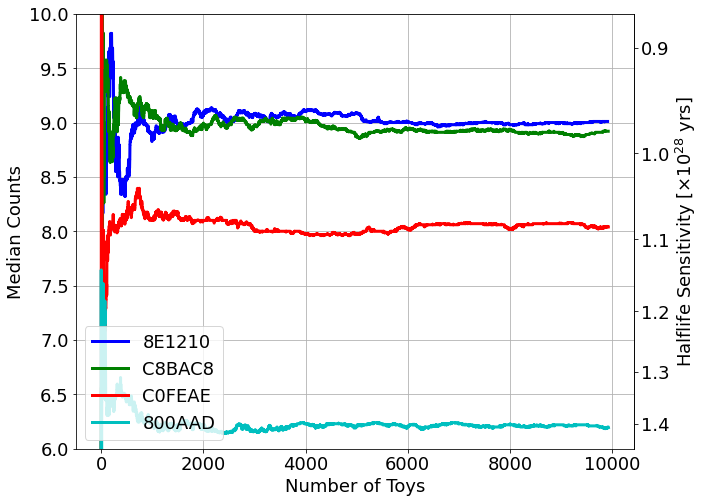

In [23]:
# Given a vector V of length N, the median of V is the middle value 
# of a sorted copy of V, V_sorted - i e., V_sorted[(N-1)/2], when N 
# is odd, and the average of the two middle values of V_sorted when 
# N is even.
# To speed things up, I use `sortedcontainers`
from sortedcontainers import SortedList

for tag in ['8E1210', 'C8BAC8', 'C0FEAE', '800AAD']:
    
    if tag not in dfdict.keys():
        h5_files = glob.glob(f'{outputdir}/*{tag}*.h5')
        if h5_files:
            df_list = [pd.read_hdf(outputdir/Path(filename)) for filename in h5_files]
            dfdict[tag] = pd.concat(df_list, ignore_index=True)
            
    df_fit = dfdict[tag]
    
    good_fit_mask = []
    for index,row in df_fit.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01\
            or row['best_fit_nll'] > 0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)

    values = df_fit['90CL_crossing'].loc[good_fit_mask]

    sl = SortedList()
    medians = []
    for n, v in enumerate(values):
        sl.add(v)
        if v % 2 == 0:  # even
            medians.append(sl[n//2])
        else:  # odd
            medians.append((sl[(n-1)//2] + sl[(n+1)//2]) / 2.)
        if v % 100 == 0:  
            print(medians[-1], ComputeHalflifeFromNumCounts(medians[-1]))

    plt.plot(np.arange(len(values)), medians, '-', linewidth=3, label=tag)
    
plt.xlabel('Number of Toys')
plt.ylabel('Median Counts')
plt.ylim((6,10))
plt.legend()
plt.grid()
sec_ax = plt.gca().secondary_yaxis('right', 
                            functions=(lambda x: ComputeHalflifeFromNumCounts(x)/1e28, ComputeCountsFromHalflife))
sec_ax.set_ylabel(r'Halflife Sensitivity [$\times 10^{28}$ yrs]')
plt.savefig(plotsdir / f'Multivar_study_convergence.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
plt.show()
